## Kaggle: Sberbank


The goal of Sberbank Russian Housing Market competition is to predict the log housing price based on a number of real estate features and economic indicators. Let's import the libraries and examine the data.

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

np.random.seed(0)


In [16]:
# load data
macro_cols = ["balance_trade", "average_provision_of_build_contract",
              "micex_rgbi_tr", "micex_cbi_tr", "mortgage_value", "mortgage_rate", "cpi", "ppi",
              "income_per_cap", "rent_price_4+room_bus", "balance_trade_growth"]
        
train_df = pd.read_csv("./data/train.csv", parse_dates = ['timestamp'])
test_df  = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])    
macro_df = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)
            
train_df['price_doc'] = np.log1p(train_df['price_doc'])

Let's see how many missing values we have

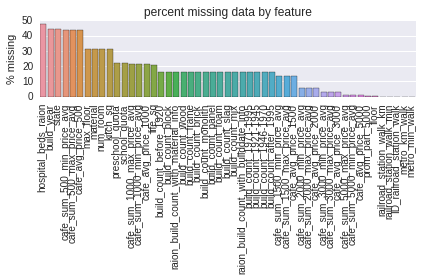

In [17]:
#nan values
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

#missing data visualization
plt.figure()
plt.xticks(rotation='90')
sns.barplot(x=train_na.index,y=train_na)
plt.title("percent missing data by feature")
plt.ylabel("% missing")
plt.tight_layout()
plt.show()

Next, we'll correct for typos and data entry errors

In [18]:
#data quality
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2007
train_df.loc[train_df['build_year'] == 0, 'build_year'] = np.nan
train_df.loc[train_df['build_year'] == 1, 'build_year'] = np.nan  
train_df.loc[train_df['build_year'] == 3, 'build_year'] = np.nan
train_df.loc[train_df['build_year'] == 71, 'build_year'] = np.nan

Let's visualize the data

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


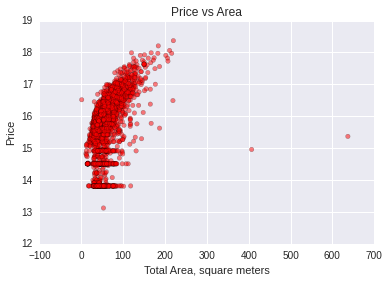

In [24]:
idx = train_df[train_df['full_sq'] > 2000].index  #remove outliers
plt.figure()
plt.scatter(train_df['full_sq'].drop(idx), train_df['price_doc'].drop(idx), c='r', alpha=0.5)
plt.title("Price vs Area")
plt.xlabel("Total Area, square meters")
plt.ylabel("Price")
plt.show()

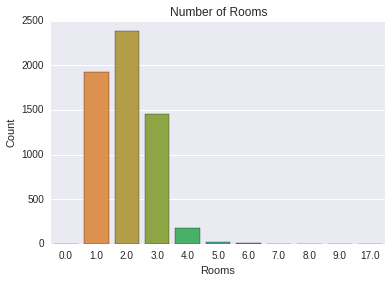

In [25]:
#room counts
plt.figure()
sns.countplot(train_df['num_room'])
plt.title("Number of Rooms")
plt.xlabel("Rooms")
plt.ylabel("Count")
plt.show()

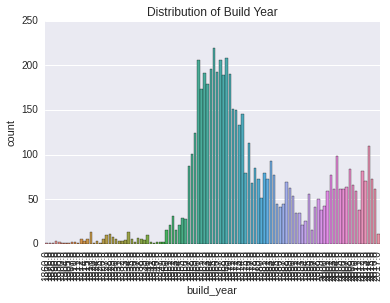

In [26]:
#build year histogram
plt.figure()
plt.xticks(rotation='90')
idx = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(idx).sort_values(by=['build_year'])
sns.countplot(by_df['build_year'])
plt.title("Distribution of Build Year")
plt.show()

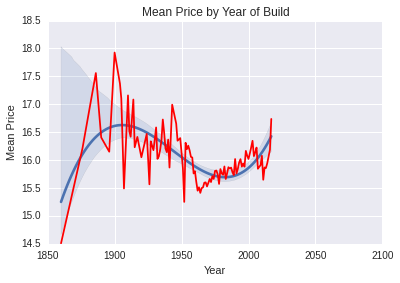

In [27]:
#mean price vs build year
plt.figure()
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
sns.regplot(x='build_year', y='price_doc', data=by_price, scatter=False, order=3, truncate=True)
plt.plot(by_price['build_year'], by_price['price_doc'], color='r')
plt.title('Mean Price by Year of Build')
plt.xlabel("Year")
plt.ylabel("Mean Price")
plt.show()


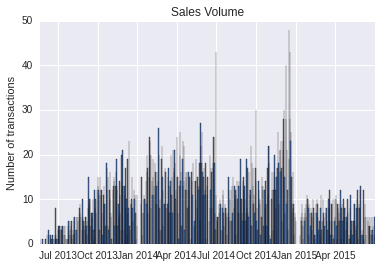

In [28]:
#sales volume
plt.figure()
ts_vc = train_df['timestamp'].value_counts()
plt.bar(left=ts_vc.index, height=ts_vc)
plt.title("Sales Volume")
plt.ylabel("Number of transactions")
plt.show()


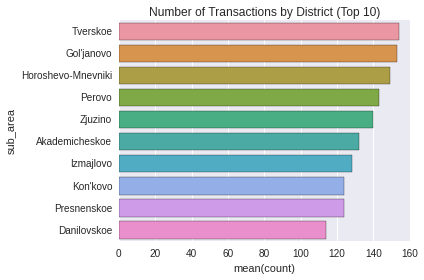

In [30]:
#volume by sub-area
plt.figure()
sa_vc = train_df['sub_area'].value_counts()
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count':sa_vc.values})
sns.barplot(x="count", y="sub_area", data=sa_vc.iloc[0:10], orient='h')
plt.title("Number of Transactions by District (Top 10)")
plt.tight_layout()    
plt.show()

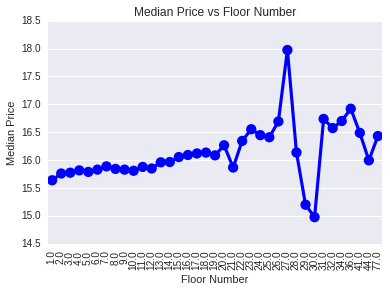

In [31]:
#price by floor
plt.figure()
fl_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(fl_df.floor.values, fl_df.price_doc.values, alpha=0.8, color='b')
plt.title("Median Price vs Floor Number")
plt.xlabel("Floor Number")
plt.ylabel("Median Price")
plt.xticks(rotation='vertical')    
plt.show()